In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col, min as spark_min, max as spark_max, avg, mean, stddev, udf, when
from pyspark.sql.functions import lit, when
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import Row
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

In [ ]:
spark = SparkSession.builder.appName("SVM").getOrCreate()
spark

In [ ]:
df = spark.read.csv('BankCustomerData_Processed.csv', header=True, inferSchema=True)
df.show()

+---+-------+-------+-------+----+---+-----+--------+-----+--------+-----------+-----------------+------------------+-------------------+------------+
|age|marital|default|housing|loan|day|month|campaign|pdays|previous|job_indexed|education_indexed|balance_normalized|duration_normalized|term_deposit|
+---+-------+-------+-------+----+---+-----+--------+-----+--------+-----------+-----------------+------------------+-------------------+------------+
| 58|      2|      0|      1|   0|  5|    5|       1|   -1|       0|          1|                1|       0.849311927|        0.466905188|           0|
| 44|      1|      0|      1|   0|  5|    5|       1|   -1|       0|          2|                0|       0.364449541|        0.270125224|           0|
| 33|      2|      0|      1|   1|  5|    5|       1|   -1|       0|          7|                0|       0.358256881|        0.135957066|           0|
| 47|      2|      0|      1|   0|  5|    5|       1|   -1|       0|          0|              

In [ ]:
selected_cols = ['age', 'campaign']

summary_df = df.select(selected_cols).describe()
summary_df.show()

+-------+-----------------+------------------+
|summary|              age|          campaign|
+-------+-----------------+------------------+
|  count|            42639|             42639|
|   mean|40.72670559816131|  2.42470508220174|
| stddev|9.999083287799715|1.6137689108778355|
|    min|               18|                 1|
|    max|               68|                 6|
+-------+-----------------+------------------+



In [ ]:
def normalize_dataframe(df, columns):
    min_max_values = {}
    for column in columns:
        min_value = df.select(spark_min(col(column))).collect()[0][0]
        max_value = df.select(spark_max(col(column))).collect()[0][0]
        min_max_values[column] = (min_value, max_value)

    normalized_data = df
    for column, (min_value, max_value) in min_max_values.items():
        new_column_name = f"{column}_normalized"
        normalized_data = normalized_data.withColumn(
            new_column_name, (col(column) - min_value) / (max_value - min_value)
        ).drop(column)

    return normalized_data

columns = ['age', 'campaign']
normalize_df = normalize_dataframe(df, columns)

In [ ]:
normalize_df = normalize_df.drop('age')
normalize_df = normalize_df.drop('campaign')

selected_cols = ['age_normalized', 'campaign_normalized']

summary_df = normalize_df.select(selected_cols).describe()
summary_df.show()

+-------+-------------------+-------------------+
|summary|     age_normalized|campaign_normalized|
+-------+-------------------+-------------------+
|  count|              42639|              42639|
|   mean|0.45453411196322185| 0.2849410164404057|
| stddev|0.19998166575599338| 0.3227537821755687|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



In [ ]:
# Chuyển thuộc tính term_deposit về cuối
selected_cols = [col for col in normalize_df.columns if col != 'term_deposit']
term_deposit_col = col('term_deposit')

new_df = normalize_df.select(selected_cols + [term_deposit_col])
new_df.show()

+-------+-------+-------+----+---+-----+-----+--------+-----------+-----------------+------------------+-------------------+--------------+-------------------+------------+
|marital|default|housing|loan|day|month|pdays|previous|job_indexed|education_indexed|balance_normalized|duration_normalized|age_normalized|campaign_normalized|term_deposit|
+-------+-------+-------+----+---+-----+-----+--------+-----------+-----------------+------------------+-------------------+--------------+-------------------+------------+
|      2|      0|      1|   0|  5|    5|   -1|       0|          1|                1|       0.849311927|        0.466905188|           0.8|                0.0|           0|
|      1|      0|      1|   0|  5|    5|   -1|       0|          2|                0|       0.364449541|        0.270125224|          0.52|                0.0|           0|
|      2|      0|      1|   1|  5|    5|   -1|       0|          7|                0|       0.358256881|        0.135957066|           

In [ ]:
def pyspark_get_dummies(df, cols):
    new_cols = []

    for col_name in cols:
        distinct_values = df.select(col_name).distinct().rdd.flatMap(lambda x: x).collect()

        for value in distinct_values:

            new_col_name = col_name + "_" + str(value)
            new_cols.append(new_col_name)

            df = df.withColumn(new_col_name, when(col(col_name) == value, lit(1)).otherwise(lit(0)))

    df = df.drop(*cols)

    return df

In [ ]:
cols_to_encode = ["marital", "day", "month", "job_indexed", "education_indexed"]

encoded_df = pyspark_get_dummies(new_df, cols_to_encode)

encoded_df.show()

+-------+-------+----+-----+--------+------------------+-------------------+--------------+-------------------+------------+---------+---------+---------+------+------+------+------+------+------+-----+------+-----+------+-----+------+-----+------+------+-----+------+-----+-----+------+-----+------+------+------+------+------+------+------+-----+------+------+--------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+-------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------------+-------------------+-------------------+-------------------+
|default|housing|loan|pdays|previous|balance_normalized|duration_normalized|age_normalized|campaign_normalized|term_deposit|marital_1|marital_2|marital_0|day_31|day_28|day_26|day_27|day_12|day_22|day_1|day_13|day_6|day_16|day_3|day_20|day_5|day_19|day_15|day_9|day_17|day_4|day_8|day_23|d

In [ ]:
train_data, test_data = encoded_df.randomSplit([0.8, 0.2], seed=42)

X_train = train_data.drop('term_deposit')
X_train = X_train.withColumn('intercept', lit(1))
y_train = train_data.select('term_deposit')

X_test = test_data.drop('term_deposit')
X_test = X_test.withColumn('intercept', lit(1))
y_test = test_data.select('term_deposit')

In [111]:
X_train_rdd = X_train.rdd.map(lambda row: np.array(row));
y_train_rdd = y_train.rdd.map(lambda row: row['term_deposit'])
y_train_rdd = y_train_rdd.map(lambda x: 1 if x == 1 else -1)

X_test_rdd = X_test.rdd.map(lambda row: np.array(row));
y_test_rdd = y_test.rdd.map(lambda row: row['term_deposit'])
y_test_rdd = y_test_rdd.map(lambda x: 1 if x == 1 else -1)

train_rdd = X_train_rdd.zip(y_train_rdd)
test_rdd = X_test_rdd.zip(y_test_rdd)

num_partitions = 4
train_rdd = train_rdd.repartition(num_partitions)

In [117]:
def svm_predict(W, X):
  pred = np.dot(X, W)
  result = 1 if pred > 0 else -1
  return result

def svm_calculate_cost_gradient(data_iter,W):
  reg_strength = 10000
  data = list(data_iter)
  if len(data) == 0:
      return np.zeros(len(data[0][0]))
  X_batch = []
  Y_batch = []
  for features, label in data:
      X_batch.append(features)
      Y_batch.append(label)
  distance = 1 - (Y_batch * np.dot(X_batch, W))
  dw = np.zeros(len(data[0][0]))
  for ind, d in enumerate(distance):
      if max(0, d) == 0:
          di = W
      else:
          di = W - (reg_strength * Y_batch[ind] * X_batch[ind])
      dw += di
  dw = dw/len(Y_batch)
  return [dw]

def svm_combine_cost_gradient(dw1, dw2):
  return (dw1 + dw2)

def svm_sgd(X, alpha = 0.01, threshold = 0.0001, n_iterations = 5000):
  num_partitions = X.getNumPartitions()
  weights = np.zeros(len(X.first()[0]))
  prev_gradient = np.inf
  for i in range(n_iterations):
    gradient = X.mapPartitions(lambda partition: svm_calculate_cost_gradient(partition,weights)).reduce(svm_combine_cost_gradient) / num_partitions
    if np.linalg.norm(prev_gradient - gradient) < threshold:
        break
    weights = weights - alpha * gradient
    prev_gradient = gradient
  return weights

In [ ]:
import time
start_time = time.time()

svm_weights = svm_sgd(train_rdd)

end_time = time.time()

In [120]:
predictions_rdd = test_rdd.map(lambda x: (x[1], svm_predict(svm_weights, x[0])))

In [121]:
predictions = predictions_rdd.collect()
predictions_df = spark.createDataFrame(predictions_rdd, ["actual", "prediction"])
predictions_df = predictions_df.withColumn("actual", when(col("actual") == -1, 0).otherwise(col("actual")))
predictions_df = predictions_df.withColumn("prediction", when(col("prediction") == -1, 0).otherwise(col("prediction")))

accuracy = predictions_df.filter(predictions_df.prediction == predictions_df.actual).count() / predictions_df.count()

print(f"Accuracy: {accuracy}")
print(f"Time running: {end_time - start_time}s")

confusion_matrix = predictions_df.groupBy("actual", "prediction").count()
labels = [0, 1]
predictions = [0, 1]
all_combinations = [(l, p) for l in labels for p in predictions]
all_combinations_df = spark.createDataFrame(all_combinations, ["actual", "prediction"])
confusion_matrix_full = all_combinations_df.join(confusion_matrix, on=["actual", "prediction"], how="left").fillna(0)
confusion_matrix_full.show()


Accuracy: 0.7287757973733584
Time running: 4145.118417263031s
+------+----------+-----+
|actual|prediction|count|
+------+----------+-----+
|     0|         1| 2243|
|     0|         0| 5484|
|     1|         0|   70|
|     1|         1|  731|
+------+----------+-----+



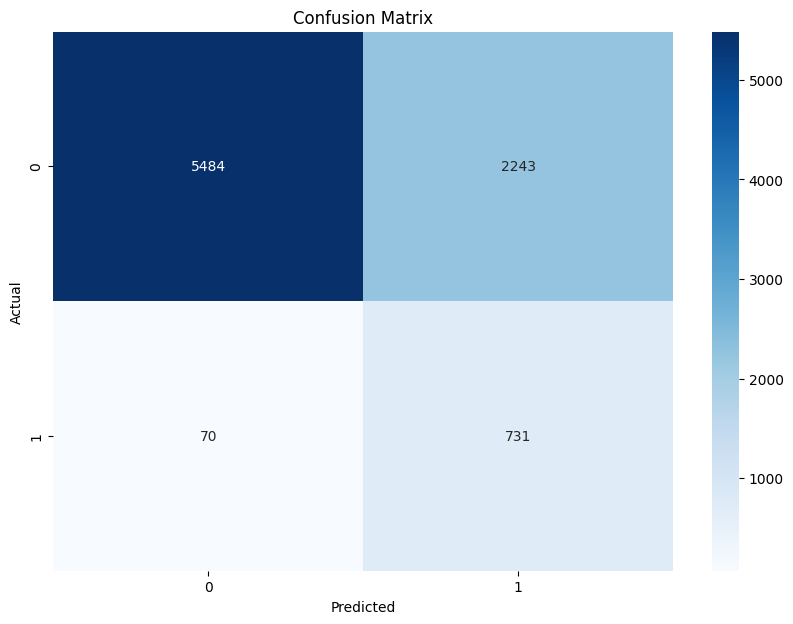

In [122]:
# Collect data for plotting
confusion_matrix_data = confusion_matrix_full.collect()

# Prepare data for the heatmap
matrix = np.zeros((2, 2))
for row in confusion_matrix_data:
    matrix[int(row['actual']), int(row['prediction'])] = row['count']

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
spark.stop()